### Topic:        Challenge Set 1   
### Subject:      Explore MTA turnstile data   
### Date:         10/01/2018   
### Name:         Maddy O'Brien Jones   
### Worked with:  Angad Chandratre, Amine Naouas, Elizabeth Riordan  (on Challenge 3)

# Challenge 1  
Open up a new IPython notebook  
Download a few MTA turnstile data files  
Read them into a pandas dataframe (pd.read_csv()), format the columns nicely, and display the first few rows.

In [2]:
import pandas as pd
import datetime as dt
df1 = pd.read_csv('turnstile_180922.txt')
df2 = pd.read_csv('turnstile_180915.txt')
df3 = pd.read_csv('turnstile_180908.txt')
df = pd.concat([df1, df2, df3])
df.rename(columns={'EXITS                                                               ': 'EXITS'}, inplace=True)
df.columns
df.DATE.value_counts().sort_index()
df.head()

,C/A,UNIT,SCP,STATION,LINENAME,DIVISION,DATE,TIME,DESC,ENTRIES,EXITS
0,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/15/2018,00:00:00,REGULAR,6759219,2291425
1,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/15/2018,04:00:00,REGULAR,6759234,2291429
2,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/15/2018,08:00:00,REGULAR,6759251,2291453
3,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/15/2018,12:00:00,REGULAR,6759330,2291532
4,A002,R051,02-00-00,59 ST,NQR456W,BMT,09/15/2018,16:00:00,REGULAR,6759538,2291574


# Challenge 2   
Let's turn this into a time series.
Create a new column that stores the date and time as a single pandas datetime object.

In [3]:
df['datetime'] = df['DATE'] + ' ' + df['TIME']
df['datetime'] = pd.to_datetime(df['datetime'], format='%m/%d/%Y %H:%M:%S')

# Challenge 3  
These counts are for every n hours (What is n?). Also, there's something odd about these "counts", what is it? Do they actually represent total entries for a time period, or something else? We want total daily entries, create a new dataframe with one row per turnstile/day and a column that gives total daily entries.

In [4]:
daily = (df
            .groupby(["C/A", "UNIT", "SCP", "STATION", "DATE"],as_index=False)
            .ENTRIES.first())

In [5]:
daily[["PREV_DATE", "PREV_ENTRIES"]] = (daily
                                            .groupby(["C/A", "UNIT", "SCP", "STATION"])["DATE", "ENTRIES"]
                                            .transform(lambda grp: grp.shift(1)))

In [6]:
daily.dropna(subset=["PREV_DATE"], axis=0, inplace=True)

In [7]:
(daily[daily["ENTRIES"] < daily["PREV_ENTRIES"]]
    .groupby(["C/A", "UNIT", "SCP", "STATION"])
    .size())

C/A    UNIT  SCP       STATION        
A007   R079  01-06-00  5 AV/59 ST          1
A011   R080  01-00-00  57 ST-7 AV         20
A025   R023  01-03-01  34 ST-HERALD SQ    20
             01-03-02  34 ST-HERALD SQ    20
A042   R086  01-00-04  PRINCE ST           1
A049   R088  02-05-00  CORTLANDT ST       17
A066   R118  00-00-00  CANAL ST           20
B018   R184  00-00-00  CORTELYOU RD        1
B020   R263  00-05-01  AVENUE H            1
C021   R212  00-00-02  59 ST              20
D011   R394  01-06-00  BAY PKWY           18
             01-06-01  BAY PKWY           18
H003   R163  01-00-02  6 AV               20
H019   R294  00-00-00  MORGAN AV           1
H023   R236  00-06-00  DEKALB AV          20
J034   R007  00-00-02  104 ST             20
JFK03  R536  00-00-02  JFK JAMAICA CT1     1
             00-00-05  JFK JAMAICA CT1     1
             00-03-02  JFK JAMAICA CT1     1
K026   R100  00-00-01  METROPOLITAN AV    20
N006A  R280  00-00-00  190 ST             20
N057   R188  00-

In [8]:
def get_daily_counts(row, max_counter):
    counter = row["ENTRIES"] - row["PREV_ENTRIES"]
    if counter < 0:
        # Maybe counter is reversed?
        counter = -counter
    if counter > max_counter:
        # Maybe counter was reset to 0? 
        print(row["ENTRIES"], row["PREV_ENTRIES"])
        counter = min(row["ENTRIES"], row["PREV_ENTRIES"])
    if counter > max_counter:
        # Check it again to make sure we're not still giving a counter that's too big
        return 0
    return counter
daily["DAILY_ENTRIES"] = daily.apply(get_daily_counts, axis=1, max_counter=1000000)

458806 3408576.0
1525 15832652.0
89 15071100.0
525054 3346426.0
6 8203336.0
0 5877814.0
85 1632278.0
685 1512945.0
1106646 5952.0
6364 1107838.0
1112083 6364.0
7082 1112083.0
1131407 8912.0
11154 1144357.0
1686 4236897.0
32375149 157468.0
78 3308167.0
0 2062000.0
440 3159530.0
940 6525436.0


# Challenge 4   
We will plot the daily time series for a turnstile.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

In [13]:
turnstile_plot = daily[(daily['C/A']=='R730')&\
                        (daily['UNIT']=='R431')&\
                        (daily['SCP']=='00-00-04')]

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
 <a list of 20 Text xticklabel objects>)

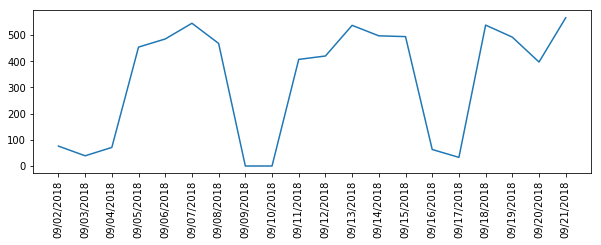

In [14]:
plt.figure(figsize=(10,3))
plt.plot(turnstile_plot['DATE'],turnstile_plot['DAILY_ENTRIES'])
plt.xticks(rotation='vertical')

# Challenge 5

So far we've been operating on a single turnstile level, let's combine turnstiles in the same ControlArea/Unit/Station combo. There are some ControlArea/Unit/Station groups that have a single turnstile, but most have multiple turnstilea-- same value for the C/A, UNIT and STATION columns, different values for the SCP column.  

We want to combine the numbers together -- for each ControlArea/UNIT/STATION combo, for each day, add the counts from each turnstile belonging to that combo.

In [15]:
station_daily = (daily
                        .groupby(["C/A", "UNIT", "STATION", "DATE"],as_index=False)
                        .DAILY_ENTRIES.first())
station_daily.head()

,C/A,UNIT,STATION,DATE,DAILY_ENTRIES
0,A002,R051,59 ST,09/02/2018,711.0
1,A002,R051,59 ST,09/03/2018,530.0
2,A002,R051,59 ST,09/04/2018,589.0
3,A002,R051,59 ST,09/05/2018,1281.0
4,A002,R051,59 ST,09/06/2018,1391.0


# Challenge 6

Similarly, combine everything in each station, and come up with a time series of [(date1, count1),(date2,count2),...] type of time series for each STATION, by adding up all the turnstiles in a station.

In [16]:
station = (station_daily
                          .groupby(['STATION', 'DATE'], as_index=False)
                          .DAILY_ENTRIES.first())
station.head()

,STATION,DATE,DAILY_ENTRIES
0,1 AV,09/02/2018,2045.0
1,1 AV,09/03/2018,1785.0
2,1 AV,09/04/2018,1651.0
3,1 AV,09/05/2018,3317.0
4,1 AV,09/06/2018,4038.0


In [17]:
time_series = station.set_index('DATE')
time_series.head()

,STATION,DAILY_ENTRIES
DATE,,
09/02/2018,1 AV,2045.0
09/03/2018,1 AV,1785.0
09/04/2018,1 AV,1651.0
09/05/2018,1 AV,3317.0
09/06/2018,1 AV,4038.0


# Challenge 7  
Plot the time series for a station.

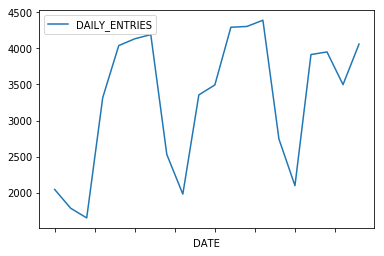

In [18]:
firstav = time_series[time_series['STATION']=='1 AV']
firstav.plot()

# Challenge 8  
Make one list of counts for one week for one station. Monday's count, Tuesday's count, etc. so it's a list of 7 counts. Make the same list for another week, and another week, and another week. plt.plot(week_count_list) for every week_count_list you created this way. You should get a rainbow plot of weekly commute numbers on top of each other.

In [20]:
station['DATE'] = pd.to_datetime(station['DATE'])
station['weekday'] = station['DATE'].dt.strftime('%A')
station['weeknumber'] = station['DATE'].dt.strftime('%U')
station.head()

,STATION,DATE,DAILY_ENTRIES,weekday,weeknumber
0,1 AV,2018-09-02,2045.0,Sunday,35
1,1 AV,2018-09-03,1785.0,Monday,35
2,1 AV,2018-09-04,1651.0,Tuesday,35
3,1 AV,2018-09-05,3317.0,Wednesday,35
4,1 AV,2018-09-06,4038.0,Thursday,35


In [21]:
firstav = station[station['STATION']=='1 AV']
firstav

,STATION,DATE,DAILY_ENTRIES,weekday,weeknumber
0,1 AV,2018-09-02,2045.0,Sunday,35
1,1 AV,2018-09-03,1785.0,Monday,35
2,1 AV,2018-09-04,1651.0,Tuesday,35
3,1 AV,2018-09-05,3317.0,Wednesday,35
4,1 AV,2018-09-06,4038.0,Thursday,35
5,1 AV,2018-09-07,4132.0,Friday,35
6,1 AV,2018-09-08,4190.0,Saturday,35
7,1 AV,2018-09-09,2530.0,Sunday,36
8,1 AV,2018-09-10,1981.0,Monday,36
9,1 AV,2018-09-11,3355.0,Tuesday,36


In [22]:
firstav35 = firstav[firstav['weeknumber']=='35']
firstav36 = firstav[firstav['weeknumber']=='36']
firstav37 = firstav[firstav['weeknumber']=='37']

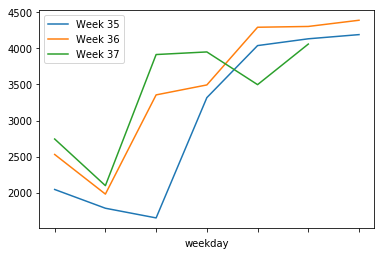

In [38]:
ax = firstav35.plot(x='weekday', y='DAILY_ENTRIES')
firstav36.plot(ax=ax, x='weekday', y='DAILY_ENTRIES')
firstav37.plot(ax=ax, x='weekday', y='DAILY_ENTRIES')
plt.legend(['Week 35', 'Week 36', 'Week 37'])

Note: Week 37 is missing the last day of data because of the shift necessary to properly find the daily entries from the cumulative values.

# Challenge 9  
Over multiple weeks, sum total ridership for each station and sort them, so you can find out the stations with the highest traffic during the time you investigate

In [39]:
total_ridership_counts = (station
                          .groupby(['STATION'], as_index=False)
                          .DAILY_ENTRIES.sum())
total_ridership_counts.sort_values(by='DAILY_ENTRIES', ascending=False).head()

,STATION,DAILY_ENTRIES
297,NEWARK HW BMEBE,133348.0
23,168 ST,130544.0
322,QUEENSBORO PLZ,92091.0
107,86 ST-2 AVE,91088.0
57,34 ST-HERALD SQ,87480.0


# Challenge 10
Make a single list of these total ridership values and plot it with  

plt.hist(total_ridership_counts)   

to get an idea about the distribution of total ridership among different stations.   

This should show you that most stations have a small traffic, and the histogram bins for large traffic volumes have small bars.   

Additional Hint:   

If you want to see which stations take the meat of the traffic, you can sort the total ridership counts and make a plt.bar graph. For this, you want to have two lists: the indices of each bar, and the values. The indices can just be 0,1,2,3,..., so you can do   

indices = range(len(total_ridership_values))   
plt.bar(indices, total_ridership_values)   

(array([126., 130.,  77.,  22.,  14.,   0.,   3.,   0.,   0.,   2.]),
 array([     0. ,  13334.8,  26669.6,  40004.4,  53339.2,  66674. ,
         80008.8,  93343.6, 106678.4, 120013.2, 133348. ]),
 <a list of 10 Patch objects>)

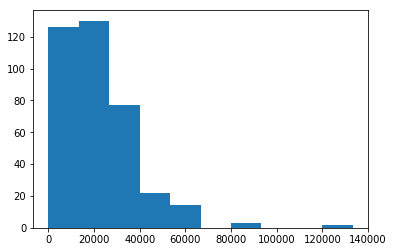

In [40]:
plt.hist(total_ridership_counts['DAILY_ENTRIES'])

<Container object of 374 artists>

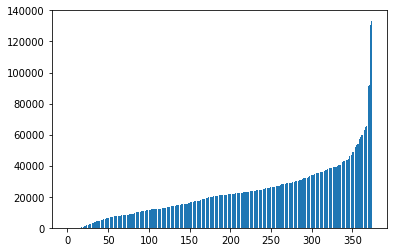

In [41]:
total_ridership_values = total_ridership_counts['DAILY_ENTRIES'].sort_values()
indices = range(len(total_ridership_values))
plt.bar(indices, total_ridership_values)